<a href="https://colab.research.google.com/github/MillionHappa/Spark/blob/main/%E6%8E%A1%E7%94%A8%E8%AA%B2%E9%A1%8C%E3%81%BE%E3%81%A8%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データのimport



In [ ]:
#import
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

import seaborn as sns

import torch.nn.functional as F

from sklearn.preprocessing import label_binarize

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#モデルの選定

In [ ]:
# CIFAR-10 用 ResNet50 の定義
def get_cifar10_resnet50():
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

model = get_cifar10_resnet50().to(device)

# # モデル初期化
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 10)
# model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 248MB/s]


In [ ]:
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
#     transforms.RandomRotation(degrees=(-180, 180)),
#     # transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),
#     # transforms.RandomErasing(p=0.8, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
#     # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
#                          std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
# ])


# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
#                          std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
# ])

# train_dataseat = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
# validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

#画像の前処理

##1 Flip, Contrast, Rotation

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 61.1MB/s]


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

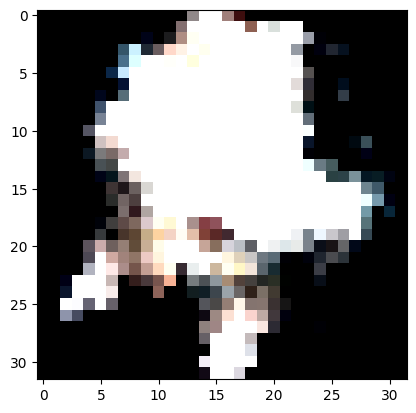

In [ ]:
imgs.size() #channel, batch, width, height
img = imgs[0]
img_permute = img.permute(1,2,0).cpu()
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)
plt.imshow(img_permute)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 2.22673303174881, acc: 0.1789827197790146, val loss: 2.068046443759443, val acc: 0.2776557505130768
epoch: 1, loss: 2.0014289921853914, acc: 0.2727527320384979, val loss: 1.8258285651953456, val acc: 0.3488418459892273
epoch: 2, loss: 1.8485322291471222, acc: 0.33043426275253296, val loss: 1.7058508323785215, val acc: 0.40045925974845886
epoch: 3, loss: 1.7270966082601615, acc: 0.37595969438552856, val loss: 1.524602861069262, val acc: 0.4668530225753784
epoch: 4, loss: 1.6065261913123836, acc: 0.421405166387558, val loss: 1.3777361674049793, val acc: 0.5158745646476746
epoch: 5, loss: 1.4893581704382552, acc: 0.46691060066223145, val loss: 1.2074202925633317, val acc: 0.5814696550369263
epoch: 6, loss: 1.3816541683879786, acc: 0.506197988986969, val loss: 1.0630596542891604, val acc: 0.6425718665122986
epoch: 7, loss: 1.2741268518180018, acc: 0.5467050671577454, val loss: 0.9547309507958044, val acc: 0.6824081540107727
epoch: 8, loss: 1.1799857480664782, acc: 0.5840930

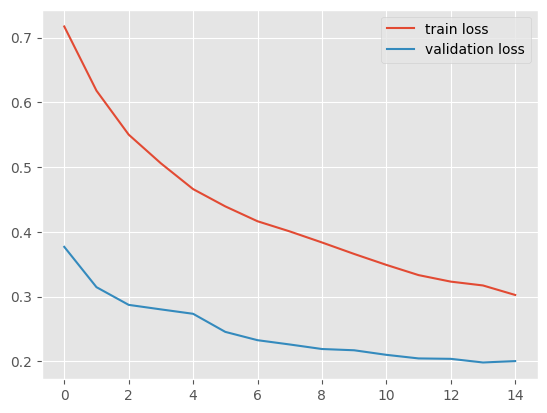

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

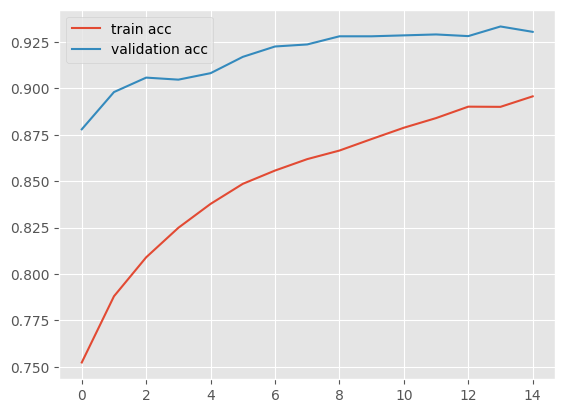

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

## Flilpのみ


In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')



epoch: 0, loss: 0.7155768908107426, acc: 0.7536588311195374, val loss: 0.6492030283989617, val acc: 0.7788538336753845
epoch: 1, loss: 0.5858067201160881, acc: 0.7984845042228699, val loss: 0.5329111659774384, val acc: 0.817292332649231
epoch: 2, loss: 0.49906598828537524, acc: 0.8297345042228699, val loss: 0.4745162749014343, val acc: 0.8375598788261414
epoch: 3, loss: 0.44090082380570284, acc: 0.8496081233024597, val loss: 0.41936823582877747, val acc: 0.8551317453384399
epoch: 4, loss: 0.39851982168429034, acc: 0.8638035655021667, val loss: 0.4041340835749532, val acc: 0.868510365486145
epoch: 5, loss: 0.3577233257149933, acc: 0.8783988952636719, val loss: 0.35875025071417943, val acc: 0.8791932463645935
epoch: 6, loss: 0.32766775789021757, acc: 0.8889955282211304, val loss: 0.35841964708920865, val acc: 0.8811900615692139
epoch: 7, loss: 0.30459151504607784, acc: 0.8963731527328491, val loss: 0.3340006217527123, val acc: 0.889776349067688
epoch: 8, loss: 0.2798825302736277, acc: 0.

🇯🇵 Accuracy: 0.9138

Classification Report:
               precision    recall  f1-score   support

       plane     0.9099    0.9390    0.9242      1000
         car     0.9492    0.9520    0.9506      1000
        bird     0.8820    0.9120    0.8968      1000
         cat     0.8434    0.8350    0.8392      1000
        deer     0.8841    0.9150    0.8993      1000
         dog     0.8904    0.8370    0.8629      1000
        frog     0.9230    0.9350    0.9290      1000
       horse     0.9547    0.9270    0.9406      1000
        ship     0.9526    0.9450    0.9488      1000
       truck     0.9505    0.9410    0.9457      1000

    accuracy                         0.9138     10000
   macro avg     0.9140    0.9138    0.9137     10000
weighted avg     0.9140    0.9138    0.9137     10000



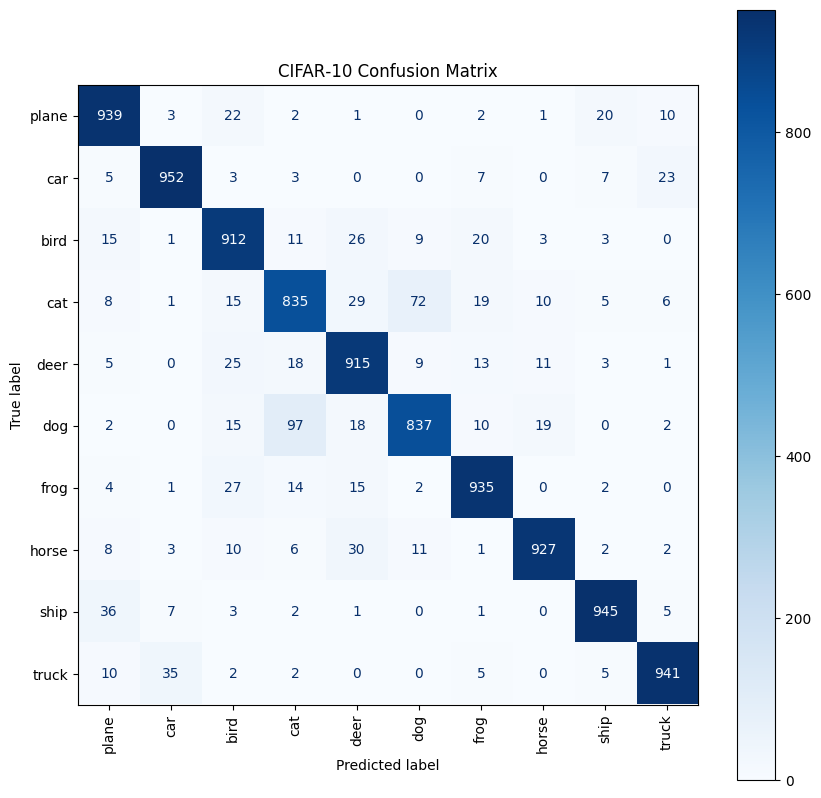

In [ ]:
# Accuracy
print("🇯🇵 Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


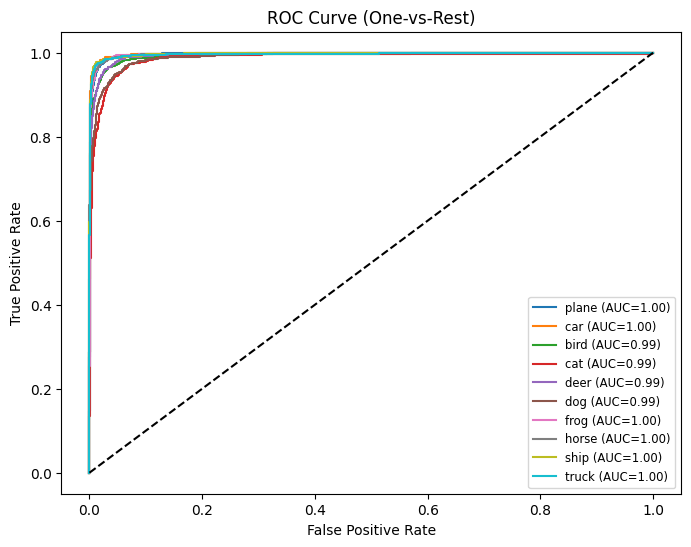

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

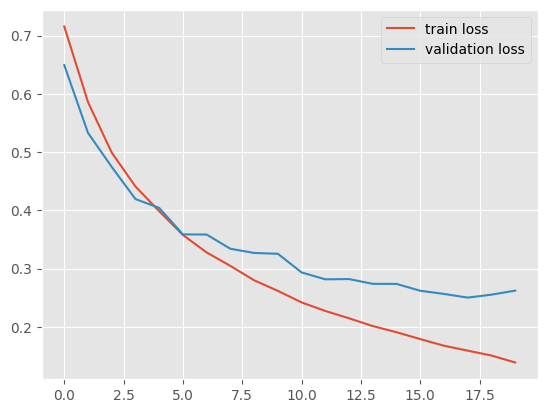

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

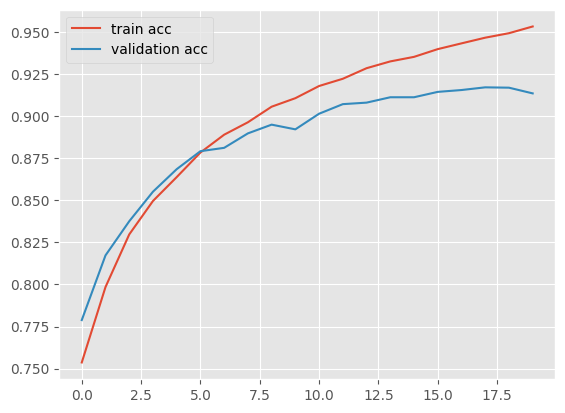

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

##Rotationのみ

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.5090576342413689, acc: 0.48548465967178345, val loss: 0.7278009514077403, val acc: 0.7956269979476929
epoch: 1, loss: 1.2065820394993134, acc: 0.5792146325111389, val loss: 0.6310151222224434, val acc: 0.8094049096107483
epoch: 2, loss: 1.0768184245433552, acc: 0.6239403486251831, val loss: 0.5918539066474658, val acc: 0.8119009733200073
epoch: 3, loss: 0.9966228615757142, acc: 0.6516115069389343, val loss: 0.5462599761379413, val acc: 0.8273761868476868
epoch: 4, loss: 0.9388821972385096, acc: 0.6706653833389282, val loss: 0.5251217029346064, val acc: 0.828973650932312
epoch: 5, loss: 0.8813034900090516, acc: 0.691938579082489, val loss: 0.49530452546981957, val acc: 0.835563063621521
epoch: 6, loss: 0.846043851309988, acc: 0.7053142786026001, val loss: 0.486302555273897, val acc: 0.8387579917907715
epoch: 7, loss: 0.8044348158900431, acc: 0.7187699675559998, val loss: 0.4555402751833486, val acc: 0.8514376878738403
epoch: 8, loss: 0.7753270353862131, acc: 0.73038625

## Mixupのみ


In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:06<00:00, 27.2MB/s]


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
args = type('', (), {})()
args.alpha = 1.0
from torch.autograd import Variable
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        img, targets_a, targets_b, lam = mixup_data(imgs, labels,
                                                       args.alpha)
        imgs, targets_a, targets_b = map(Variable, (imgs,
                                                      targets_a, targets_b))
        optimizer.zero_grad()
        output = model(imgs)
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        correct = lam * pred.eq(targets_a).float().mean() + (1 - lam) * pred.eq(targets_b).float().mean()
        running_acc += correct

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 2.2704002921274666, acc: 0.155673086643219, val loss: 2.10239613246613, val acc: 0.3367611765861511
epoch: 1, loss: 2.171443505921733, acc: 0.2518206238746643, val loss: 1.8251892990959337, val acc: 0.48132985830307007
epoch: 2, loss: 2.085089038902571, acc: 0.31124189496040344, val loss: 1.5974495167168565, val acc: 0.5680910348892212
epoch: 3, loss: 2.0229428604636066, acc: 0.35164305567741394, val loss: 1.4393790914608648, val acc: 0.6305910348892212
epoch: 4, loss: 1.9878936096101103, acc: 0.37727877497673035, val loss: 1.3710318819021645, val acc: 0.6759185194969177
epoch: 5, loss: 1.951113452685619, acc: 0.39915016293525696, val loss: 1.2983305949372606, val acc: 0.7076677083969116
epoch: 6, loss: 1.936696077643948, acc: 0.4123115837574005, val loss: 1.2157615442245533, val acc: 0.7371205687522888
epoch: 7, loss: 1.8977087732316285, acc: 0.43408992886543274, val loss: 1.1703822054802038, val acc: 0.7572883367538452
epoch: 8, loss: 1.8621324022000827, acc: 0.450753

## ZCAのみ


In [ ]:
# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算

        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 2.0145366374910907, acc: 0.30312299728393555, val loss: 1.63034524970923, val acc: 0.4429911971092224
epoch: 1, loss: 1.3908761385840174, acc: 0.5176743268966675, val loss: 1.143639691721517, val acc: 0.6110223531723022
epoch: 2, loss: 1.0097672641467987, acc: 0.6495521664619446, val loss: 0.8566759608614559, val acc: 0.7102635502815247
epoch: 3, loss: 0.7675558448943738, acc: 0.7360244989395142, val loss: 0.6933928172999677, val acc: 0.7683705687522888
epoch: 4, loss: 0.6279752043600808, acc: 0.7866082787513733, val loss: 0.5777905793806997, val acc: 0.8052116632461548
epoch: 5, loss: 0.531569271021292, acc: 0.8177983164787292, val loss: 0.5062371738992941, val acc: 0.8321685194969177
epoch: 6, loss: 0.4580732473599476, acc: 0.8436100482940674, val loss: 0.4557269393636015, val acc: 0.8444488644599915
epoch: 7, loss: 0.4031853373385894, acc: 0.8636236190795898, val loss: 0.4765816554189109, val acc: 0.8557308316230774
epoch: 8, loss: 0.36357559676991774, acc: 0.8765994

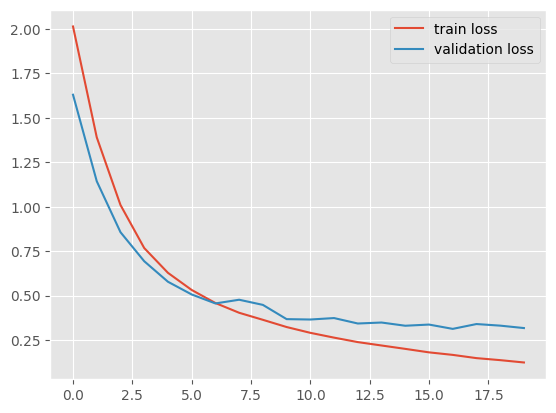

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

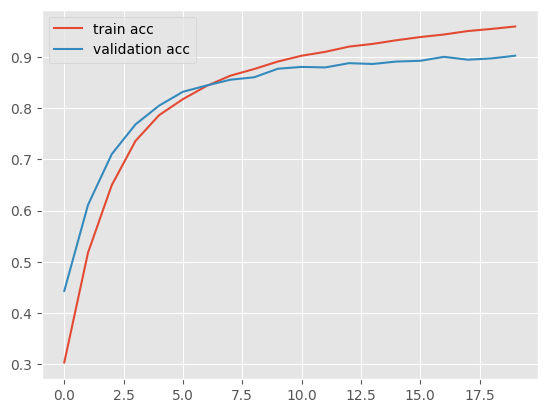

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()